In [1]:
import keras

Using TensorFlow backend.


In [2]:
keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=(600,800,3), pooling=None, classes=2)

In [3]:
import os
import numpy as np
import cv2
path = '/Users/evergreen/Desktop/Geodesic/data/'
# for i in range(588)
i=0
image= cv2.imread(os.path.join(path,'input/',str(6192+i)+'.jpg'))
# image= cv2.imread(os.path.join(path,'output/',str(6192+i)+'.bmp'))
image3=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image3.shape

(600, 800)

In [23]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

base_model = VGG19(include_top=False,weights='imagenet',input_shape=(224,224,3))#shape cannot be changed
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv2').output)

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# img=keras.preprocessing.image.load_img(os.path.join(path,'input/',str(6192+i)+'.jpg'), target_size=(224, 224))
img=keras.preprocessing.image.load_img(os.path.join(path,'membrane/train/image',str(i)+'.png'), target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features_in = model.predict(x)

features_in.shape

(1, 224, 224, 64)

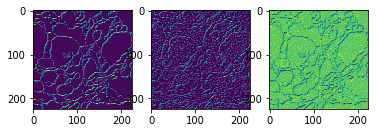

In [30]:
img=keras.preprocessing.image.load_img(os.path.join(path,'membrane/train/label',str(i)+'.png'), target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features_out = model.predict(x)

import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.imshow(features_out[0,:,:,1])
plt.subplot(1,3,2)
plt.imshow(features_in[0,:,:,1])
plt.subplot(1,3,3)
plt.imshow(features_in[0,:,:,1]-features_out[0,:,:,1])


In [179]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Test VGG19 Validity

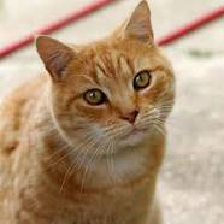

In [90]:
img_path="/Users/evergreen/Desktop/Geodesic/data/cat.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img

In [91]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
base_model.predict(x).argmax()#285='Egyptian cat'
#see https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

285

# Define U-net

In [133]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend

def unet(pretrained_weights = None,input_size = (224,224,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [134]:
umodel=unet()
umodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 224, 224, 64) 640         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_98[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_99[0][0]                  
__________________________________________________________________________________________________
conv2d_100

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


# Load Images

In [162]:
from keras.preprocessing.image import ImageDataGenerator
# import numpy as np 
# import os
# import glob
# import skimage.io as io
# import skimage.transform as trans
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (224,224),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
        

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,path,'input','output',data_gen_args,save_to_dir = None)
# myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)


In [141]:

model = unet()
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=10,epochs=5,callbacks=[model_checkpoint])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/5
Found 206 images belonging to 1 classes.
Found 206 images belonging to 1 classes.
10/10 [==============================] - 73s 7s/step - loss: 0.6918 - acc: 0.9849

Epoch 00001: loss improved from inf to 0.69177, saving model to unet_membrane.hdf5
Epoch 2/5
10/10 [==============================] - 81s 8s/step - loss: 0.3300 - acc: 0.9976

Epoch 00002: loss improved from 0.69177 to 0.33000, saving model to unet_membrane.hdf5
Epoch 3/5
10/10 [==============================] - 85s 8s/step - loss: 0.0438 - acc: 0.9976

Epoch 00003: loss improved from 0.33000 to 0.04380, saving model to unet_membrane.hdf5
Epoch 4/5
10/10 [==============================] - 84s 8s/step - loss: 0.0389 - acc: 0.9977

Epoch 00004: loss improved from 0.04380 to 0.03888, saving model to unet_membrane.hdf5
Epoch 5/5
10/10 [==============================] - 84s 8s/step - loss: 0.0356 - acc: 0.9978

Epoch 00005: loss improved from 0.03888 to 0.03561, saving model to unet_membrane.hdf5


# Test Model
crack data needs to be modified (by augmenting the crack by 4 pixels)

In [153]:
def testGenerator(test_path,num_image = 30,target_size = (224,224),flag_multi_class = False,as_gray = True):
    for i in range(588):
        img = io.imread(os.path.join(test_path,"%d.jpg"%(i+6192)),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.jpg"%(i+6192)),img)

In [154]:
import skimage.io as io
import skimage.transform as trans
testGene = testGenerator(os.path.join(path,'input'))
model = unet()
model.load_weights("unet.hdf5")
results = model.predict_generator(testGene,30,verbose=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


30/30 [==============================] - 31s 1s/step


In [160]:
saveResult(os.path.join(path,'result/'),results*255)

# test on membrane data

In [171]:
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model.load_weights("unet_membrane.hdf5")
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=200,epochs=40,callbacks=[model_checkpoint])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/40
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
200/200 [==============================] - 1324s 7s/step - loss: 0.2830 - acc: 0.8738

Epoch 00001: loss improved from inf to 0.28302, saving model to unet_membrane.hdf5
Epoch 2/40


KeyboardInterrupt: 

In [172]:
def testGenerator(test_path,num_image = 30,target_size = (224,224),flag_multi_class = False,as_gray = True):
    for i in range(588):
        img = io.imread(os.path.join(test_path,"%d.png"%(i+0)),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.jpg"%(i+0)),img)

testGene = testGenerator('data/membrane/train/image')
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,10,verbose=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


10/10 [==============================] - 13s 1s/step


In [174]:
saveResult(os.path.join(path,'result/'),results)

# Topology Loss

In [ ]:
import keras.backend as K
from keras import metrics

base_model = VGG19(include_top=False,weights='imagenet',input_shape=(224,224,3))#shape cannot be changed
layer1 = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv2').output)
layer2 = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_conv2').output)
layer3 = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_conv4').output)

def myloss(mu,layer1,layer2,layer3):
    def loss(y_true, y_pred):
        y_pred_f1 = layer1.predict(y_pred)
        y_true_f1 = layer1.predict(y_true)
        y_pred_f2 = layer2.predict(y_pred)
        y_true_f2 = layer2.predict(y_true)
        y_pred_f3 = layer3.predict(y_pred)
        y_true_f3 = layer3.predict(y_true)
        return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + mu * K.mean(K.square(y_pred_f - y_true_f), axis=-1)
    return loss

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

model.compile(loss=myloss(mu,layer1,layer2,layer3),metrics=[recall,metrics.binary_accuracy])